[Repo Link](https://github.com/habibaelghazouly/ML-projects.git)

## Imports

In [1]:
import sys
sys.path.append("..")
from src import preprocess_mnist
from src import NNModel
from src import train_model_nn
from src import plot_training_curves
from src import detect_convergence, plot_convergence 
from src.NNs.helpers import get_gradients
from src import LogisticRegressionModel
from src import train_model, test_model
from src import plot_curves, print_confusion_matrix
from src import SoftmaxRegressionModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import pandas as pd
import time

## Displaying Non-Flattened MNIST Images

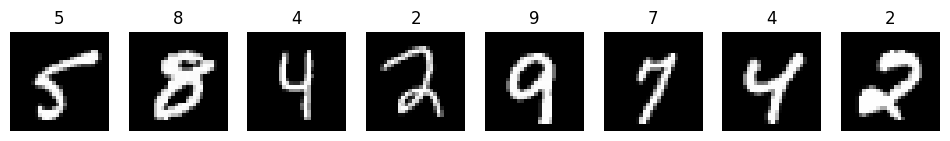

In [2]:
train_loader, val_loader, test_loader = preprocess_mnist(flatten=False)

images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(str(labels[i].item()))
    axes[i].axis('off')
plt.show()


## Displaying Flattened MNIST Data Information

In [3]:
train_loader, val_loader, test_loader = preprocess_mnist(batch_size=64, augment=False, flatten=True)

images, labels = next(iter(train_loader))
print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Example labels: {labels[:10]}")

Images batch shape: torch.Size([64, 784])
Labels batch shape: torch.Size([64])
Example labels: tensor([0, 2, 8, 7, 2, 3, 7, 6, 9, 4])


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Filter 0 and 1 only
def filter_binary(loader):
    X, y = [], []
    for img, label in loader.dataset:
        if label in [0, 1]:
            X.append(img)
            y.append(label)
    X = torch.stack(X)
    y = torch.tensor(y)
    ds = torch.utils.data.TensorDataset(X, y)
    return torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)

train_loader_bin = filter_binary(train_loader)
val_loader_bin = filter_binary(val_loader)
test_loader_bin = filter_binary(test_loader)

## Logistic Regression Model

In [6]:
model_log = LogisticRegressionModel(input_dim=784)
loss_fn = nn.BCELoss()

## Train

In [7]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model_log, train_loader_bin, val_loader_bin,
    epochs=30, lr=0.01, device=device, loss_fn=loss_fn, binary=True
)

Epoch [1/30] Train Loss: 0.2352, Val Loss: 0.1083, Train Acc: 0.9828, Val Acc: 0.9941


Epoch [2/30] Train Loss: 0.0795, Val Loss: 0.0653, Train Acc: 0.9963, Val Acc: 0.9945


Epoch [3/30] Train Loss: 0.0529, Val Loss: 0.0493, Train Acc: 0.9964, Val Acc: 0.9945


Epoch [4/30] Train Loss: 0.0410, Val Loss: 0.0408, Train Acc: 0.9967, Val Acc: 0.9949


Epoch [5/30] Train Loss: 0.0342, Val Loss: 0.0355, Train Acc: 0.9972, Val Acc: 0.9949


Epoch [6/30] Train Loss: 0.0297, Val Loss: 0.0318, Train Acc: 0.9975, Val Acc: 0.9949


Epoch [7/30] Train Loss: 0.0265, Val Loss: 0.0291, Train Acc: 0.9976, Val Acc: 0.9949


Epoch [8/30] Train Loss: 0.0240, Val Loss: 0.0269, Train Acc: 0.9979, Val Acc: 0.9949


Epoch [9/30] Train Loss: 0.0221, Val Loss: 0.0253, Train Acc: 0.9979, Val Acc: 0.9949


Epoch [10/30] Train Loss: 0.0206, Val Loss: 0.0239, Train Acc: 0.9978, Val Acc: 0.9949


Epoch [11/30] Train Loss: 0.0193, Val Loss: 0.0227, Train Acc: 0.9979, Val Acc: 0.9949


Epoch [12/30] Train Loss: 0.0182, Val Loss: 0.0217, Train Acc: 0.9979, Val Acc: 0.9949


Epoch [13/30] Train Loss: 0.0173, Val Loss: 0.0209, Train Acc: 0.9979, Val Acc: 0.9953


Epoch [14/30] Train Loss: 0.0165, Val Loss: 0.0201, Train Acc: 0.9979, Val Acc: 0.9953


Epoch [15/30] Train Loss: 0.0158, Val Loss: 0.0195, Train Acc: 0.9979, Val Acc: 0.9957


Epoch [16/30] Train Loss: 0.0152, Val Loss: 0.0189, Train Acc: 0.9979, Val Acc: 0.9961


Epoch [17/30] Train Loss: 0.0147, Val Loss: 0.0183, Train Acc: 0.9979, Val Acc: 0.9961


Epoch [18/30] Train Loss: 0.0142, Val Loss: 0.0179, Train Acc: 0.9979, Val Acc: 0.9961


Epoch [19/30] Train Loss: 0.0137, Val Loss: 0.0174, Train Acc: 0.9979, Val Acc: 0.9964


Epoch [20/30] Train Loss: 0.0133, Val Loss: 0.0170, Train Acc: 0.9979, Val Acc: 0.9964


Epoch [21/30] Train Loss: 0.0129, Val Loss: 0.0166, Train Acc: 0.9979, Val Acc: 0.9964


Epoch [22/30] Train Loss: 0.0126, Val Loss: 0.0163, Train Acc: 0.9979, Val Acc: 0.9964


Epoch [23/30] Train Loss: 0.0123, Val Loss: 0.0160, Train Acc: 0.9979, Val Acc: 0.9964


Epoch [24/30] Train Loss: 0.0120, Val Loss: 0.0157, Train Acc: 0.9979, Val Acc: 0.9964


Epoch [25/30] Train Loss: 0.0117, Val Loss: 0.0154, Train Acc: 0.9979, Val Acc: 0.9964


Epoch [26/30] Train Loss: 0.0115, Val Loss: 0.0152, Train Acc: 0.9979, Val Acc: 0.9964


Epoch [27/30] Train Loss: 0.0112, Val Loss: 0.0149, Train Acc: 0.9979, Val Acc: 0.9964


Epoch [28/30] Train Loss: 0.0110, Val Loss: 0.0147, Train Acc: 0.9979, Val Acc: 0.9964


Epoch [29/30] Train Loss: 0.0108, Val Loss: 0.0145, Train Acc: 0.9979, Val Acc: 0.9964


Epoch [30/30] Train Loss: 0.0106, Val Loss: 0.0143, Train Acc: 0.9979, Val Acc: 0.9964


## Plots


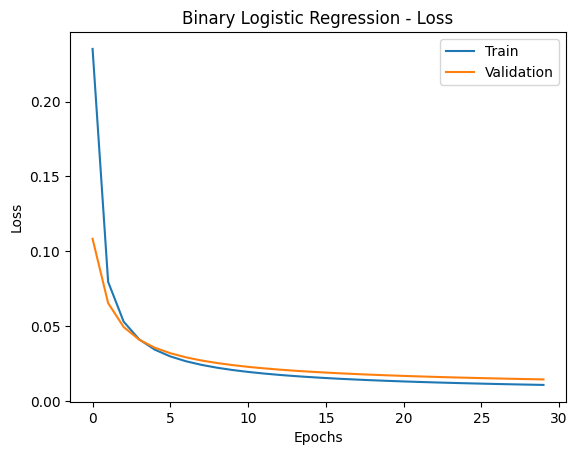

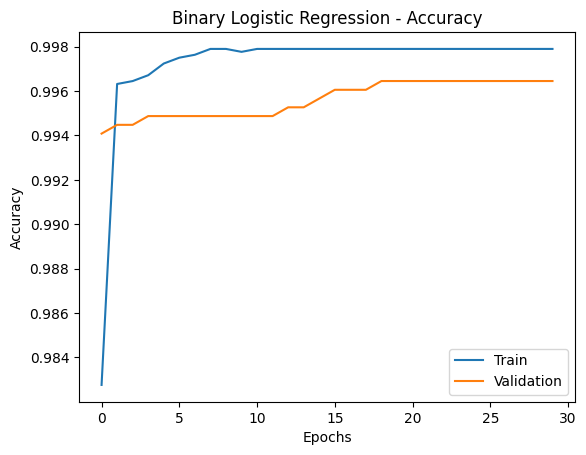

In [8]:
plot_curves(train_losses, val_losses, "Binary Logistic Regression - Loss", "Loss")
plot_curves(train_accs, val_accs, "Binary Logistic Regression - Accuracy", "Accuracy")

## Test

Test Accuracy: 0.9980


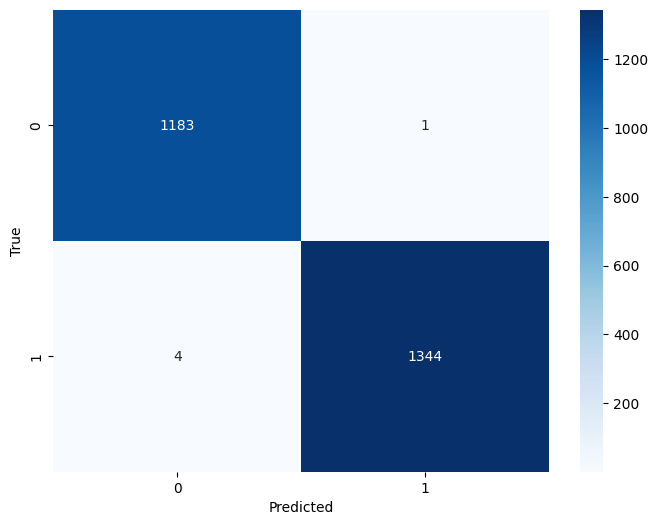

In [9]:
acc, cm = test_model(model_log, test_loader_bin, device, binary=True)
print(f"Test Accuracy: {acc:.4f}")
print_confusion_matrix(cm, classes=["0", "1"])

## Softmax Regression

In [10]:
# model
model_softmax = SoftmaxRegressionModel(input_dim=784, num_classes=10)
loss_fn = nn.CrossEntropyLoss()

In [11]:
# train
train_loader, val_loader, test_loader = preprocess_mnist(flatten=True)

train_losses, val_losses, train_accs, val_accs = train_model(
    model_softmax, train_loader, val_loader,
    epochs=30, lr=0.01, device=device, loss_fn=loss_fn
)

Epoch [1/30] Train Loss: 1.1752, Val Loss: 0.7686, Train Acc: 0.7719, Val Acc: 0.8399


Epoch [2/30] Train Loss: 0.6553, Val Loss: 0.5945, Train Acc: 0.8546, Val Acc: 0.8602


Epoch [3/30] Train Loss: 0.5442, Val Loss: 0.5247, Train Acc: 0.8698, Val Acc: 0.8702


Epoch [4/30] Train Loss: 0.4908, Val Loss: 0.4854, Train Acc: 0.8774, Val Acc: 0.8758


Epoch [5/30] Train Loss: 0.4581, Val Loss: 0.4595, Train Acc: 0.8824, Val Acc: 0.8822


Epoch [6/30] Train Loss: 0.4356, Val Loss: 0.4407, Train Acc: 0.8859, Val Acc: 0.8855


Epoch [7/30] Train Loss: 0.4186, Val Loss: 0.4268, Train Acc: 0.8890, Val Acc: 0.8867


Epoch [8/30] Train Loss: 0.4054, Val Loss: 0.4153, Train Acc: 0.8909, Val Acc: 0.8901


Epoch [9/30] Train Loss: 0.3947, Val Loss: 0.4059, Train Acc: 0.8934, Val Acc: 0.8911


Epoch [10/30] Train Loss: 0.3857, Val Loss: 0.3981, Train Acc: 0.8951, Val Acc: 0.8938


Epoch [11/30] Train Loss: 0.3781, Val Loss: 0.3917, Train Acc: 0.8969, Val Acc: 0.8948


Epoch [12/30] Train Loss: 0.3715, Val Loss: 0.3856, Train Acc: 0.8983, Val Acc: 0.8966


Epoch [13/30] Train Loss: 0.3658, Val Loss: 0.3807, Train Acc: 0.8997, Val Acc: 0.8977


Epoch [14/30] Train Loss: 0.3607, Val Loss: 0.3762, Train Acc: 0.9002, Val Acc: 0.8988


Epoch [15/30] Train Loss: 0.3561, Val Loss: 0.3720, Train Acc: 0.9012, Val Acc: 0.9001


Epoch [16/30] Train Loss: 0.3520, Val Loss: 0.3684, Train Acc: 0.9021, Val Acc: 0.9015


Epoch [17/30] Train Loss: 0.3483, Val Loss: 0.3651, Train Acc: 0.9031, Val Acc: 0.9022


Epoch [18/30] Train Loss: 0.3448, Val Loss: 0.3621, Train Acc: 0.9040, Val Acc: 0.9032


Epoch [19/30] Train Loss: 0.3416, Val Loss: 0.3593, Train Acc: 0.9048, Val Acc: 0.9040


Epoch [20/30] Train Loss: 0.3387, Val Loss: 0.3569, Train Acc: 0.9049, Val Acc: 0.9038


Epoch [21/30] Train Loss: 0.3360, Val Loss: 0.3544, Train Acc: 0.9058, Val Acc: 0.9049


Epoch [22/30] Train Loss: 0.3335, Val Loss: 0.3524, Train Acc: 0.9064, Val Acc: 0.9052


Epoch [23/30] Train Loss: 0.3311, Val Loss: 0.3504, Train Acc: 0.9073, Val Acc: 0.9058


Epoch [24/30] Train Loss: 0.3289, Val Loss: 0.3483, Train Acc: 0.9077, Val Acc: 0.9069


Epoch [25/30] Train Loss: 0.3267, Val Loss: 0.3466, Train Acc: 0.9086, Val Acc: 0.9070


Epoch [26/30] Train Loss: 0.3248, Val Loss: 0.3450, Train Acc: 0.9088, Val Acc: 0.9068


Epoch [27/30] Train Loss: 0.3229, Val Loss: 0.3433, Train Acc: 0.9095, Val Acc: 0.9083


Epoch [28/30] Train Loss: 0.3212, Val Loss: 0.3420, Train Acc: 0.9099, Val Acc: 0.9079


Epoch [29/30] Train Loss: 0.3195, Val Loss: 0.3407, Train Acc: 0.9104, Val Acc: 0.9084


Epoch [30/30] Train Loss: 0.3179, Val Loss: 0.3391, Train Acc: 0.9109, Val Acc: 0.9097


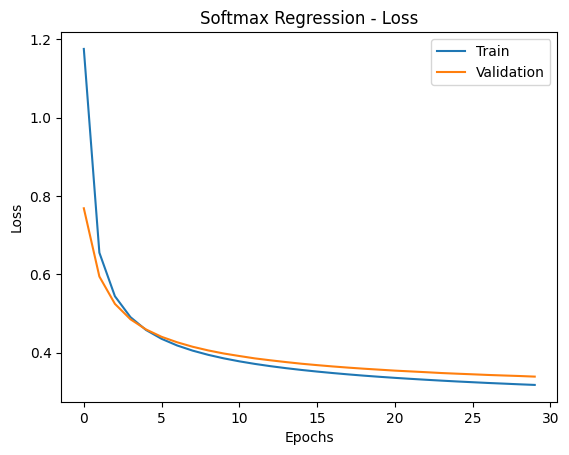

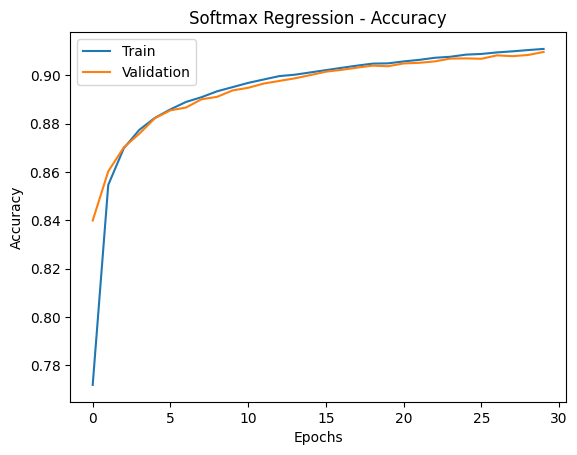

In [12]:
# plot
plot_curves(train_losses, val_losses, "Softmax Regression - Loss", "Loss")
plot_curves(train_accs, val_accs, "Softmax Regression - Accuracy", "Accuracy")

Test Accuracy: 0.9063


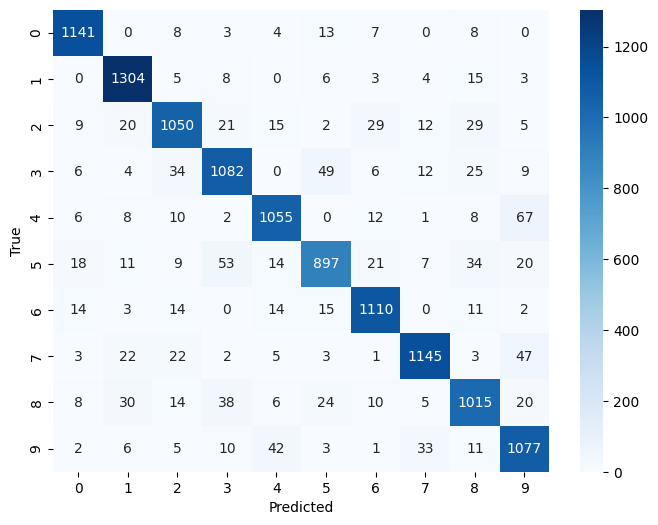

In [13]:
# test
acc, cm = test_model(model_softmax, test_loader, device)
print(f"Test Accuracy: {acc:.4f}")
print_confusion_matrix(cm, classes=[str(i) for i in range(10)])

## Neural Network Model

Epoch 1/10 | Train Loss: 1.2113 | Train Acc: 67.02% | Val Loss: 0.5298 | Val Acc: 86.35%
New best model found (val_loss=0.5298)
Checkpoint saved at: ./checkpoints/mnist.pth
Epoch 2/10 | Train Loss: 0.4092 | Train Acc: 88.70% | Val Loss: 0.3600 | Val Acc: 90.05%
New best model found (val_loss=0.3600)
Checkpoint saved at: ./checkpoints/mnist.pth
Epoch 3/10 | Train Loss: 0.3213 | Train Acc: 90.68% | Val Loss: 0.3125 | Val Acc: 91.12%
New best model found (val_loss=0.3125)
Checkpoint saved at: ./checkpoints/mnist.pth
Epoch 4/10 | Train Loss: 0.2804 | Train Acc: 91.90% | Val Loss: 0.2859 | Val Acc: 91.95%
New best model found (val_loss=0.2859)
Checkpoint saved at: ./checkpoints/mnist.pth
Epoch 5/10 | Train Loss: 0.2535 | Train Acc: 92.71% | Val Loss: 0.2667 | Val Acc: 92.59%
New best model found (val_loss=0.2667)
Checkpoint saved at: ./checkpoints/mnist.pth
Epoch 6/10 | Train Loss: 0.2312 | Train Acc: 93.34% | Val Loss: 0.2529 | Val Acc: 92.77%
New best model found (val_loss=0.2529)
Checkpo

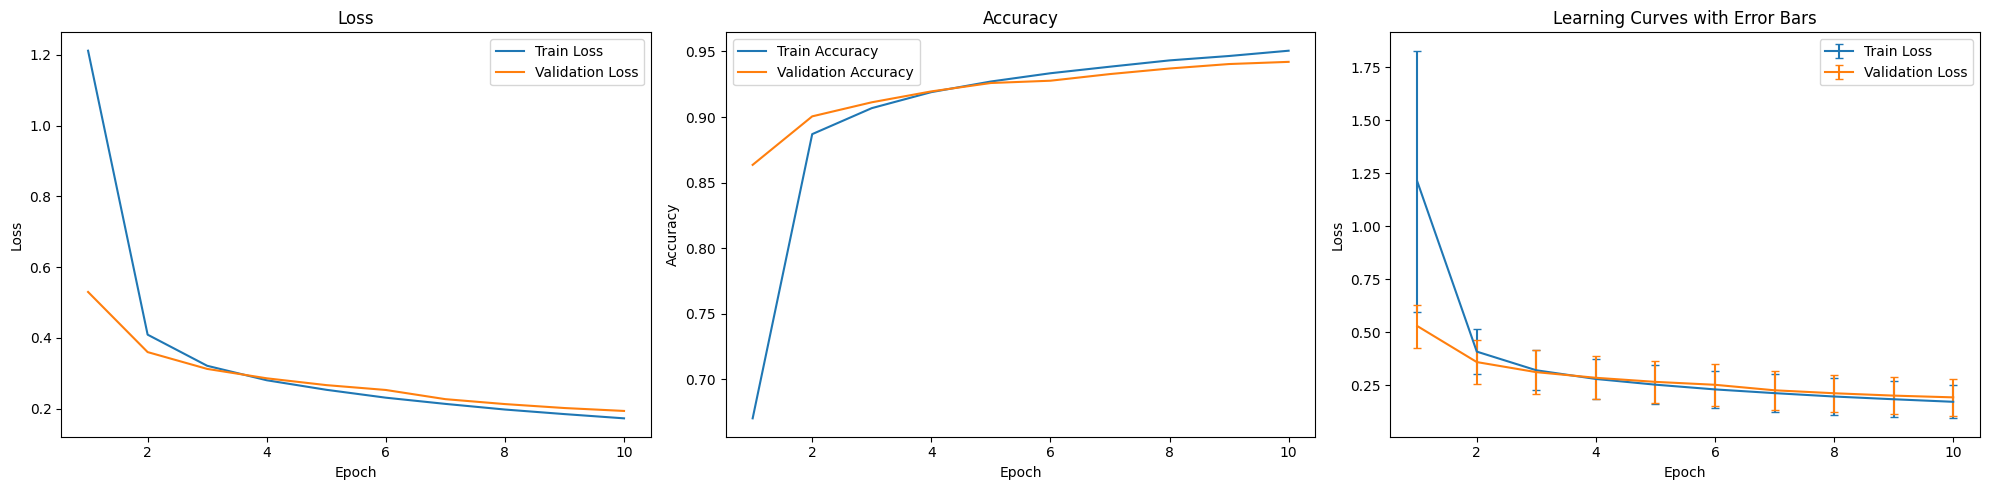

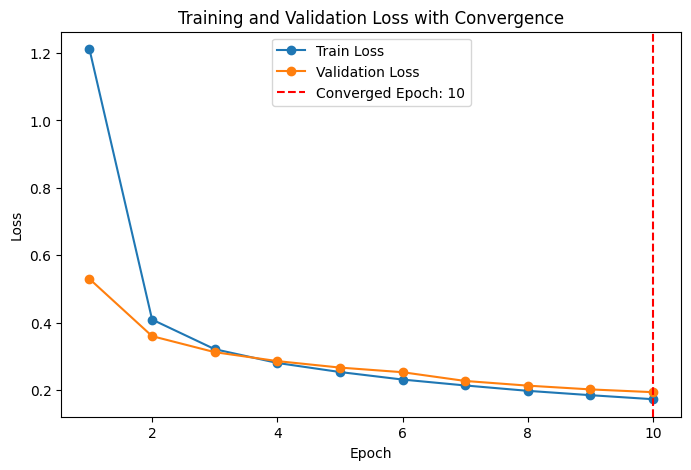

In [14]:
# Model, loss, optimizer
model = NNModel().to(device)
model.apply(model._init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 10

checkpoint_path = "./checkpoints/mnist.pth"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

train_loader, val_loader, test_loader = preprocess_mnist(batch_size=64, augment=False, flatten=True)

# Train
history = train_model_nn(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, device=device, checkpoint_path=checkpoint_path)

# Plot
plot_training_curves(history)
conv_epoch = detect_convergence(history["val_loss_mean"])
plot_convergence(history["train_loss_mean"], history["val_loss_mean"], conv_epoch)


# Analysis


### 1. Learning Rate Analysis

Training with learning rate: 0.001
Epoch 1/10 | Train Loss: 2.1825 | Train Acc: 22.86% | Val Loss: 2.0593 | Val Acc: 34.38%
New best model found (val_loss=2.0593)
Epoch 2/10 | Train Loss: 1.9129 | Train Acc: 43.29% | Val Loss: 1.7554 | Val Acc: 52.48%
New best model found (val_loss=1.7554)
Epoch 3/10 | Train Loss: 1.5772 | Train Acc: 59.15% | Val Loss: 1.4006 | Val Acc: 66.31%
New best model found (val_loss=1.4006)
Epoch 4/10 | Train Loss: 1.2338 | Train Acc: 71.35% | Val Loss: 1.0876 | Val Acc: 74.79%
New best model found (val_loss=1.0876)
Epoch 5/10 | Train Loss: 0.9704 | Train Acc: 77.81% | Val Loss: 0.8777 | Val Acc: 79.27%
New best model found (val_loss=0.8777)
Epoch 6/10 | Train Loss: 0.8005 | Train Acc: 81.08% | Val Loss: 0.7448 | Val Acc: 81.69%
New best model found (val_loss=0.7448)
Epoch 7/10 | Train Loss: 0.6897 | Train Acc: 83.30% | Val Loss: 0.6561 | Val Acc: 83.55%
New best model found (val_loss=0.6561)
Epoch 8/10 | Train Loss: 0.6131 | Train Acc: 84.66% | Val Loss: 0.592

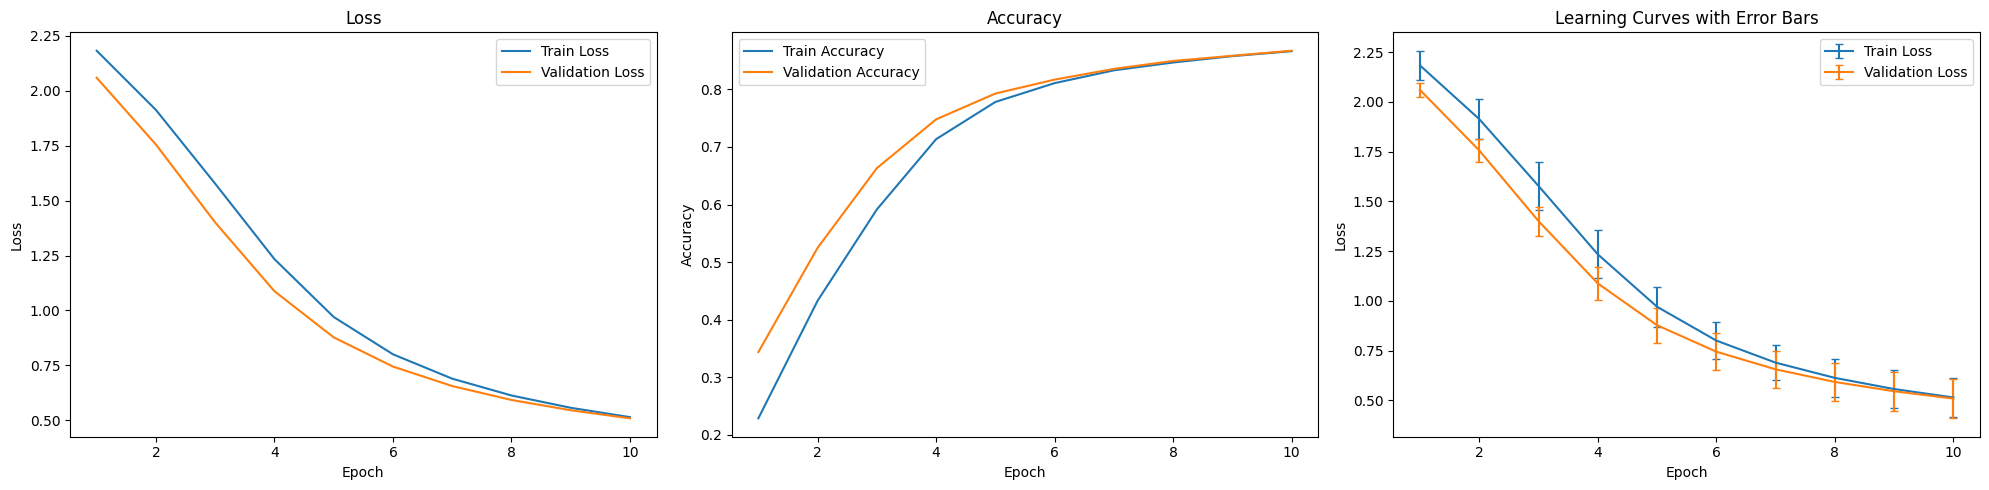

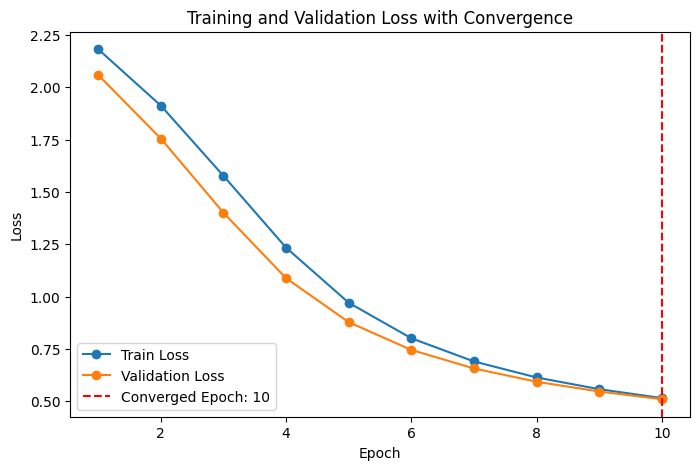

Training with learning rate: 0.01
Epoch 1/10 | Train Loss: 1.1148 | Train Acc: 70.81% | Val Loss: 0.5066 | Val Acc: 86.98%
New best model found (val_loss=0.5066)
Epoch 2/10 | Train Loss: 0.4012 | Train Acc: 88.82% | Val Loss: 0.3746 | Val Acc: 88.92%
New best model found (val_loss=0.3746)
Epoch 3/10 | Train Loss: 0.3165 | Train Acc: 90.76% | Val Loss: 0.3076 | Val Acc: 91.36%
New best model found (val_loss=0.3076)
Epoch 4/10 | Train Loss: 0.2763 | Train Acc: 92.06% | Val Loss: 0.2730 | Val Acc: 92.28%
New best model found (val_loss=0.2730)
Epoch 5/10 | Train Loss: 0.2494 | Train Acc: 92.83% | Val Loss: 0.2603 | Val Acc: 92.55%
New best model found (val_loss=0.2603)
Epoch 6/10 | Train Loss: 0.2284 | Train Acc: 93.47% | Val Loss: 0.2336 | Val Acc: 93.26%
New best model found (val_loss=0.2336)
Epoch 7/10 | Train Loss: 0.2106 | Train Acc: 93.97% | Val Loss: 0.2244 | Val Acc: 93.45%
New best model found (val_loss=0.2244)
Epoch 8/10 | Train Loss: 0.1947 | Train Acc: 94.36% | Val Loss: 0.2153

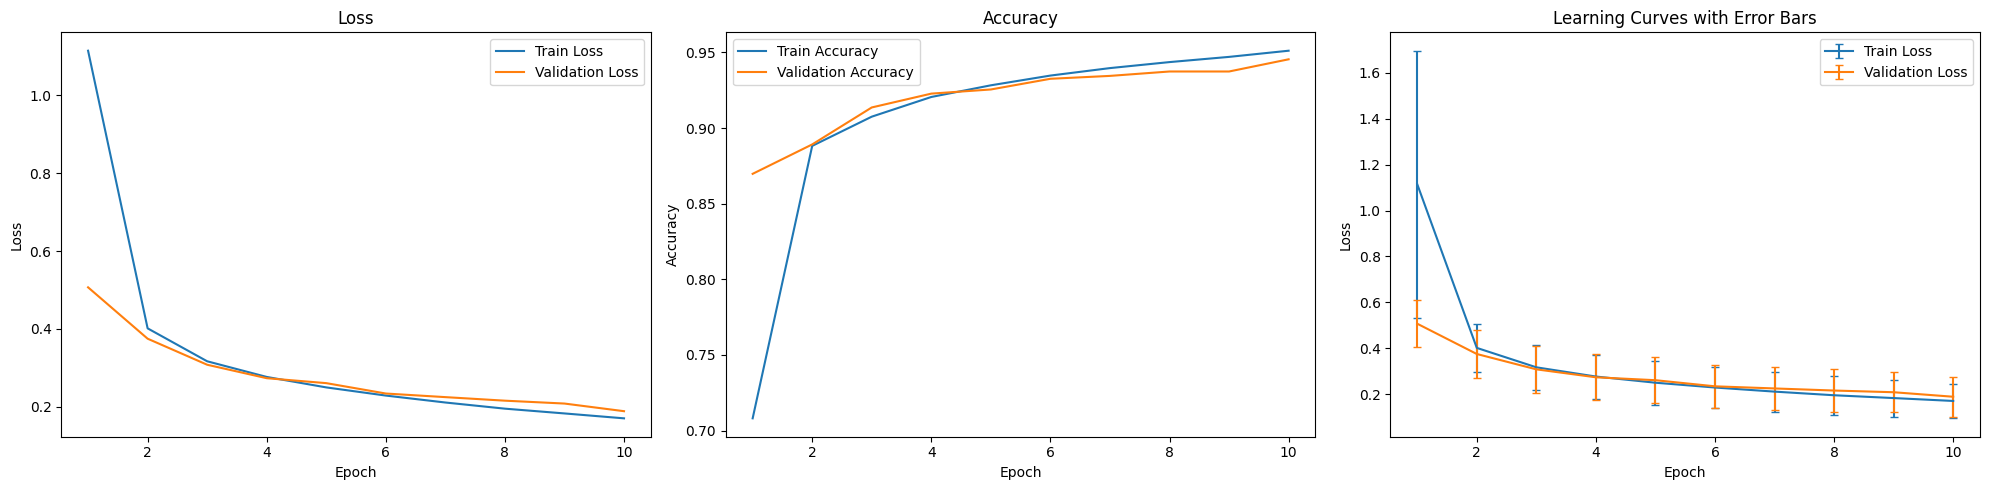

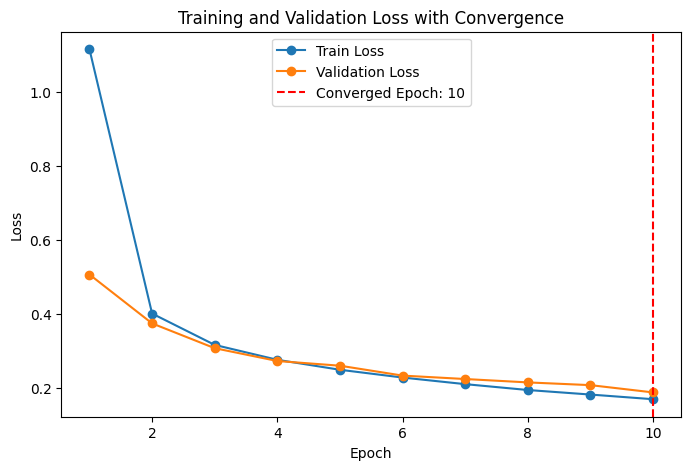

Training with learning rate: 0.1
Epoch 1/10 | Train Loss: 0.4144 | Train Acc: 87.65% | Val Loss: 0.2073 | Val Acc: 93.92%
New best model found (val_loss=0.2073)
Epoch 2/10 | Train Loss: 0.1691 | Train Acc: 94.87% | Val Loss: 0.1647 | Val Acc: 94.91%
New best model found (val_loss=0.1647)
Epoch 3/10 | Train Loss: 0.1153 | Train Acc: 96.55% | Val Loss: 0.2666 | Val Acc: 91.96%
No improvement. Patience: 1/3
Epoch 4/10 | Train Loss: 0.0850 | Train Acc: 97.41% | Val Loss: 0.1193 | Val Acc: 96.00%
New best model found (val_loss=0.1193)
Epoch 5/10 | Train Loss: 0.0635 | Train Acc: 98.12% | Val Loss: 0.1026 | Val Acc: 96.90%
New best model found (val_loss=0.1026)
Epoch 6/10 | Train Loss: 0.0496 | Train Acc: 98.47% | Val Loss: 0.0856 | Val Acc: 97.39%
New best model found (val_loss=0.0856)
Epoch 7/10 | Train Loss: 0.0375 | Train Acc: 98.90% | Val Loss: 0.1037 | Val Acc: 96.97%
No improvement. Patience: 1/3
Epoch 8/10 | Train Loss: 0.0295 | Train Acc: 99.17% | Val Loss: 0.0849 | Val Acc: 97.46%


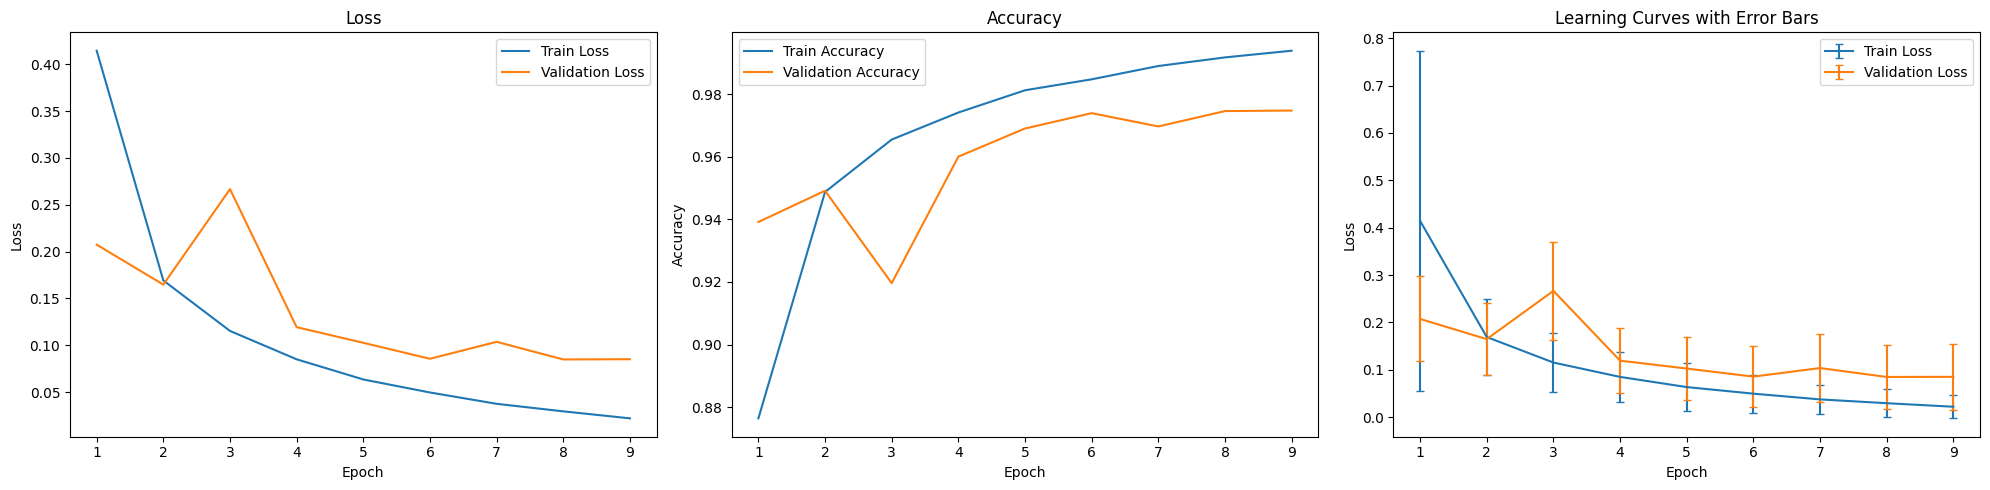

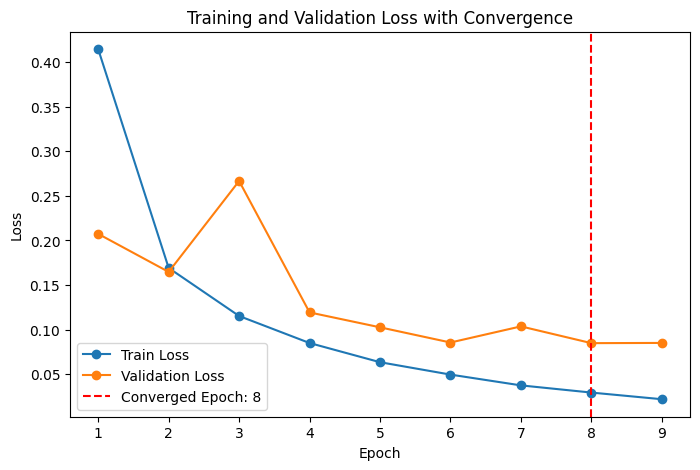

Training with learning rate: 1.0
Epoch 1/10 | Train Loss: nan | Train Acc: 10.19% | Val Loss: nan | Val Acc: 9.87%
No improvement. Patience: 1/3
Epoch 2/10 | Train Loss: nan | Train Acc: 9.88% | Val Loss: nan | Val Acc: 9.87%
No improvement. Patience: 2/3
Epoch 3/10 | Train Loss: nan | Train Acc: 9.87% | Val Loss: nan | Val Acc: 9.87%
No improvement. Patience: 3/3
Early stopping triggered!


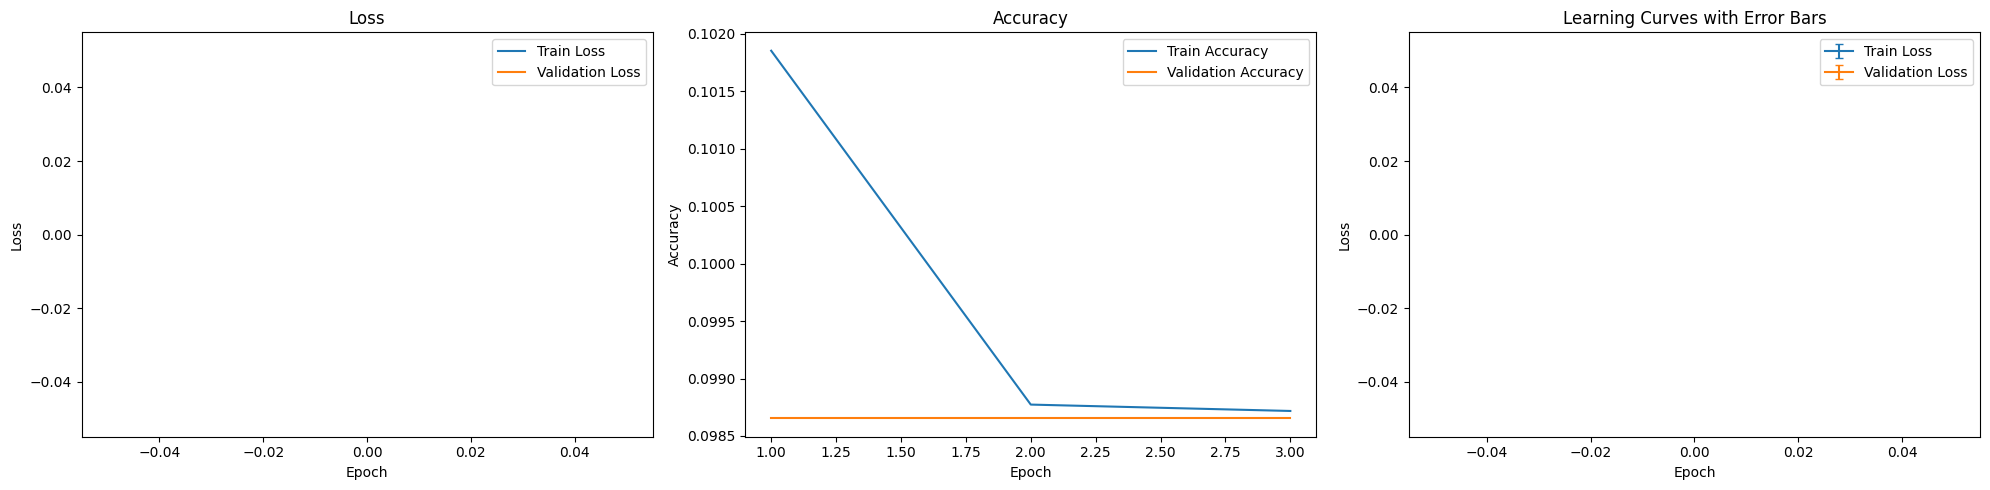

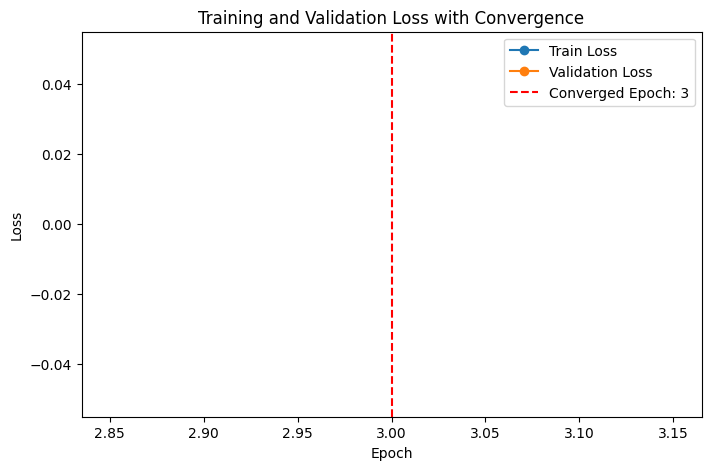

LR 0.001 → Final Val Acc: 86.71%
LR 0.01  → Final Val Acc: 94.55%
LR 0.1   → Final Val Acc: 97.47%
LR 1.0   → Final Val Acc: 9.87%

Best Learning Rate: 0.1 with Val Acc = 97.47%


In [15]:
# Test values : [0.001, 0.01, 0.1, 1.0]
learning_rates = [0.001, 0.01, 0.1, 1.0]

results_lr = {}
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = NNModel().to(device)
    model.apply(model._init_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    result = train_model_nn(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, device=device)
    results_lr[lr] = result
    plot_training_curves(result)
    conv_epoch = detect_convergence(result["val_loss_mean"])
    plot_convergence(result["train_loss_mean"], result["val_loss_mean"], conv_epoch)

# best lr 
best_lr = None
best_acc = 0.0

for lr, history in results_lr.items():
    val_acc = history["val_acc_mean"][-1]
    print(f"LR {lr:<5} → Final Val Acc: {val_acc*100:.2f}%")
    if val_acc > best_acc:
        best_acc = val_acc
        best_lr = lr

print(f"\nBest Learning Rate: {best_lr} with Val Acc = {best_acc*100:.2f}%")


### 2. Batch Size Analysis


In [ ]:
# get the full-batch sample and calculating gradient

full_batch_images, full_batch_labels = next(iter(train_loader))
full_batch_images, full_batch_labels = full_batch_images.to(device), full_batch_labels.to(device)

model = NNModel().to(device)
model.apply(model._init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)    
full_result = train_model_nn(model, train_loader, val_loader, criterion, optimizer, epochs=10, device=device)

full_batch_gradients = get_gradients(model, criterion, full_batch_images, full_batch_labels)

# Test Values : [16, 32, 64, 128]
batch_sizes = [16, 32, 64, 128]
epochs = 10
results_bs = {} 
grad_noise_results = []

for bs in batch_sizes:  
    print(f"Training with batch size: {bs}")
    train_loader_bs, val_loader_bs, test_loader_bs = preprocess_mnist(batch_size=bs, augment=False, flatten=True)
   
    # model, loss, optimizer
    model = NNModel().to(device)
    model.apply(model._init_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    start_time = time.time()
    result = train_model_nn(model, train_loader_bs, val_loader_bs, criterion, optimizer, epochs=epochs, device=device)
    train_time = time.time() - start_time
    results_bs[bs] = result

    final_val_acc = result["val_acc_mean"][-1]
 
    print(f"----- Final Val Acc: {final_val_acc*100:.2f}% | Train Time: {train_time:.2f}s -----")


    # Random stochastic batch
    batch_inputs, batch_targets = next(iter(DataLoader(train_loader_bs.dataset, batch_size=bs, shuffle=True)))
    batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
    
    stoch_grads = get_gradients(model, criterion, batch_inputs.view(batch_inputs.size(0), -1), batch_targets)
    
    # Gradient noise 
    grad_noise = [sg - tg for sg, tg in zip(stoch_grads, full_batch_gradients)]
    noise_norm = torch.sqrt(sum([g.pow(2).sum() for g in grad_noise])).item()
    
    grad_noise_results.append((bs, final_val_acc * 100, train_time, noise_norm))
    print(f"----- Gradient Noise : {noise_norm:.6f} -----")


summary_df = pd.DataFrame(grad_noise_results, columns=["Batch Size", "Val Accuracy (%)", "Train Time (s)", "Gradient Noise"])
display(summary_df)

 
# best batch size
best_bs = None
best_acc = 0.0  
for bs, history in results_bs.items():
    val_acc = history["val_acc_mean"][-1]
    print(f"BS {bs:<5} → Final Val Acc: {val_acc*100:.2f}%")
    if val_acc > best_acc:
        best_acc = val_acc
        best_bs = bs


#  visualization
plt.figure(figsize=(6,4))
plt.plot(summary_df["Batch Size"], summary_df["Gradient Noise"], marker='o')
plt.title("Gradient Noise vs Batch Size (MNIST)")
plt.xlabel("Batch Size")
plt.ylabel("Gradient Noise")
plt.grid(True)
plt.show()

print(f"\nBest Batch Size: {best_bs} with Val Acc = {best_acc*100:.2f}%")


Epoch 1/10 | Train Loss: 1.1519 | Train Acc: 69.63% | Val Loss: 0.5065 | Val Acc: 86.25%
New best model found (val_loss=0.5065)
Epoch 2/10 | Train Loss: 0.4039 | Train Acc: 88.98% | Val Loss: 0.3616 | Val Acc: 90.07%
New best model found (val_loss=0.3616)
Epoch 3/10 | Train Loss: 0.3212 | Train Acc: 90.84% | Val Loss: 0.3189 | Val Acc: 90.79%
New best model found (val_loss=0.3189)
Epoch 4/10 | Train Loss: 0.2816 | Train Acc: 91.99% | Val Loss: 0.2807 | Val Acc: 92.14%
New best model found (val_loss=0.2807)
Epoch 5/10 | Train Loss: 0.2537 | Train Acc: 92.75% | Val Loss: 0.2589 | Val Acc: 92.56%
New best model found (val_loss=0.2589)
Epoch 6/10 | Train Loss: 0.2326 | Train Acc: 93.33% | Val Loss: 0.2419 | Val Acc: 93.03%
New best model found (val_loss=0.2419)
Epoch 7/10 | Train Loss: 0.2140 | Train Acc: 93.79% | Val Loss: 0.2320 | Val Acc: 93.25%
New best model found (val_loss=0.2320)
Epoch 8/10 | Train Loss: 0.1987 | Train Acc: 94.31% | Val Loss: 0.2168 | Val Acc: 93.52%
New best model 

### 3. Architecture Analysis

In [ ]:
layers = [2, 3, 4, 5]
neurons_per_layer = [64, 128, 256, 512]
epochs = 2
results_arch = {}

for num_layers in layers:
    for neurons in neurons_per_layer:
        print(f"Training with {num_layers} layers and {neurons} neurons per layer")

        model = NNModel(hidden_sizes=[neurons]*num_layers).to(device)
        model.apply(model._init_weights)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
        result = train_model_nn(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, device=device)
      
        results_arch[(num_layers, neurons)] = result

arch_df = pd.DataFrame(
    [(num_layers, neurons, res["val_acc_mean"][-1] * 100,) 
     for (num_layers, neurons), res in results_arch.items()],
    columns=["Num Layers", "Neurons per Layer", "Val Accuracy (%)"]
)
display(arch_df)            

best_row = arch_df.loc[arch_df["Val Accuracy (%)"].idxmax()]
print(f"\nBest Architecture: {int(best_row['Num Layers'])} layers × {int(best_row['Neurons per Layer'])} neurons")
print(f"Validation Accuracy: {best_row['Val Accuracy (%)']:.2f}%")